In [9]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib qt

In [10]:
# Camera calibration

# get the path to the calibration images
images = glob.glob('camera_cal/*.jpg')

In [11]:
# decide chessboard dimensions
nx = 9
ny = 6

In [12]:
# loop through all the images to get image points (the coordinates of the corners)

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)


for image in images:
    
    img = cv2.imread(image)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


Text(0.5, 1.0, 'Undistorted Image')

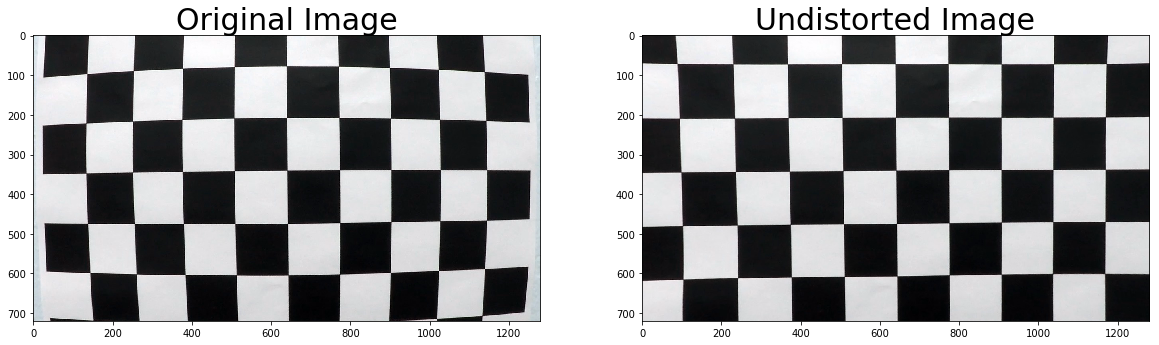

In [13]:

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',undist)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
#plt.imsave("output_images/undistort.jpg", undist)

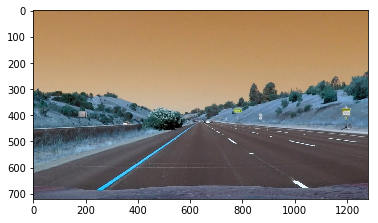

In [14]:
# read in an image to perform the test on setting threshold
image = cv2.imread('test_images/straight_lines1.jpg')
image_copy = image.copy()

# show the original image
plt.imshow(image_copy)

In [7]:
image.shape

(720, 1280, 3)

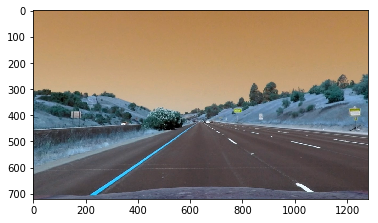

In [15]:
# undistort the image
undist_image = cv2.undistort(image_copy, mtx, dist, None, mtx)
plt.imshow(undist_image)
#plt.imsave("output_images/undistorted_test5.jpg", undist_image)

In [16]:
gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)

In [ ]:
'''
image_LAB = cv2.cvtColor(undist_image, cv2.COLOR_BGR2LAB)
L_channel = hls[:,:,0]
A_channel = hls[:,:,1]
B_channel = hls[:,:,2]
f, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(20,10))
axis1.imshow(L_channel)
axis1.set_title('L Channel', fontsize=20)
axis2.imshow(A_channel)
axis2.set_title('A Channel', fontsize=20)
axis3.imshow(B_channel)
axis3.set_title('B Channel', fontsize=20)
'''

In [ ]:
'''
thresh = (140, 170)
b_binary = np.zeros_like(B_channel)
b_binary[(B_channel > thresh[0]) & (B_channel <= thresh[1])] = 1
plt.imshow(b_binary)
'''

Text(0.5, 1.0, 'S Channel')

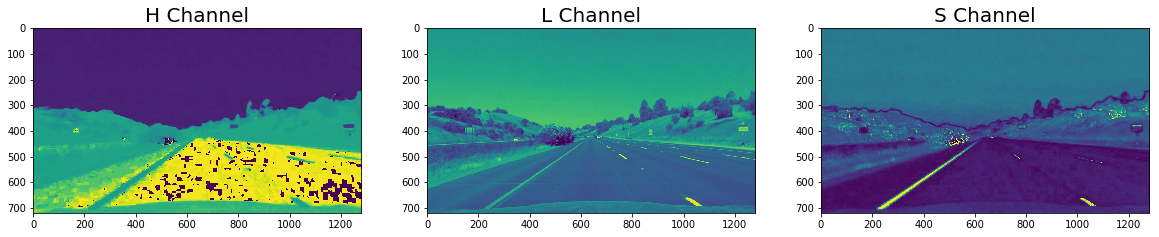

In [17]:
# convert image to HLS color space to check which one shows the lanes best

hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
H_channel = hls[:,:,0]
L_channel = hls[:,:,1]
S_channel = hls[:,:,2]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(H_channel)
ax1.set_title('H Channel', fontsize=20)
ax2.imshow(L_channel)
ax2.set_title('L Channel', fontsize=20)
ax3.imshow(S_channel)
ax3.set_title('S Channel', fontsize=20)

# obviously, the S Channel picks up the lanes best

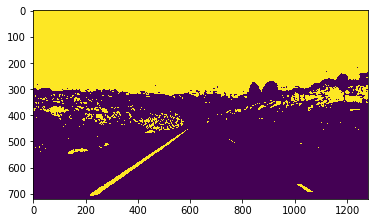

In [18]:
thresh = (90, 255)
s_binary = np.zeros_like(S_channel)
s_binary[(S_channel > thresh[0]) & (S_channel <= thresh[1])] = 1
plt.imshow(s_binary)

In [19]:
# this pipeline processed the image by applying sobelx and choosing HLS's S channel to highlight the lanes, 
# the pipeline will produce a binary image

def binary_pipeline(image, s_thresh=(170, 255), sx_thresh=(100, 200)):
    image = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # apply Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary

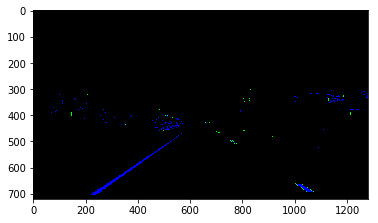

In [20]:
edited_image = binary_pipeline(undist_image, s_thresh=(170, 255), sx_thresh=(100, 200))
plt.imshow(edited_image)
plt.imsave("output_images/binary_image.jpg", edited_image)

In [21]:
# estimated begining point height, and ending point height
beg_point = 470
end_point = 720

In [22]:
# draw the source points
# functions borrowed from project 1
# region of interest
# draw
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    
    # calculate each line's slope
    slopes = []
    i = 0
    for line in lines:
        slopes.append((line[0][3] - line[0][1]) / (line[0][2] - line[0][0]))
        i += 1
    
    # group lines by +ve and -ve slopes, +ve is left, -ve is right
    left_lines = []
    right_lines = []
    left_slope_sum = 0
    right_slope_sum = 0
    
    j = 0
    for slope in slopes:
        if slope > 0:
            left_lines.append(lines[j])
            left_slope_sum += slope
        else:
            right_lines.append(lines[j])
            right_slope_sum += slope
        j += 1
    
    # averaging the slopes
    left_slope_avg = left_slope_sum/len(left_lines)
    right_slope_avg = right_slope_sum/len(right_lines)
    # get a random pt
    
    left_point_index = np.random.randint(len(left_lines))
    left_line = left_lines[left_point_index]
    left_point = [left_line[0][0], left_line[0][1]]
    
    if left_slope_avg < 50 and left_slope_avg > -50:
        upper_left_x = int((beg_point - left_point[1] + left_slope_avg * left_point[0]) / left_slope_avg)
        lower_left_x = int((end_point - left_point[1] + left_slope_avg * left_point[0]) / left_slope_avg)
        img = cv2.line(img, (upper_left_x, beg_point), (lower_left_x, end_point), color, thickness)
        
    right_point_index = np.random.randint(len(right_lines))
    right_line = right_lines[right_point_index]
    right_point = [right_line[0][0], right_line[0][1]]
    
    if right_slope_avg < 50 and right_slope_avg > -50:
        upper_right_x = int((beg_point - right_point[1] + right_slope_avg * right_point[0]) / right_slope_avg )
        lower_right_x = int((end_point - right_point[1] + right_slope_avg * right_point[0]) / right_slope_avg )
        img = cv2.line(img, (upper_right_x, beg_point), (lower_right_x, end_point), color, thickness)
        
    return right_slope_avg, left_slope_avg, right_point, left_point
    
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    right_slope, left_slope, right_point, left_point = draw_lines(line_img, lines)
    
    return line_img, right_slope, left_slope, right_point, left_point

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

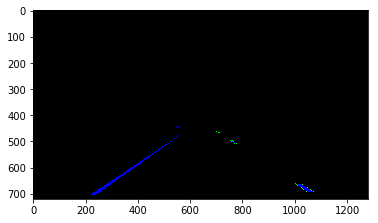

In [23]:
imshape = edited_image.shape
vertices = np.array([[(0,imshape[0]),(570, 435), (650, 435), (imshape[1],imshape[0])]], dtype=np.int32)

# mark the region of interest (the lanes area)
masked_edges = region_of_interest(edited_image, vertices)
plt.imshow(masked_edges)

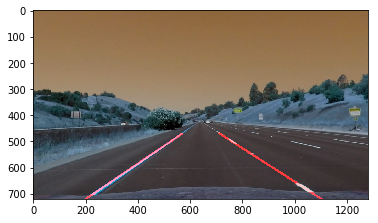

In [24]:
# run Hough transformation and draw the lanes in red
masked = cv2.cvtColor(masked_edges, cv2.COLOR_BGR2GRAY)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100 #minimum number of pixels making up a line
max_line_gap = 160   # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
line_image, right_slope, left_slope, right_point, left_point = hough_lines(masked, rho, theta, threshold, min_line_length, max_line_gap)

# Draw the lines on the edge image
lines_edges = weighted_img(line_image, undist_image)
plt.imshow(lines_edges)
#plt.imsave("output_images/after_hough.jpg", lines_edges)

In [25]:
# get source points and dest points 
# calculating source points coordinate
print(left_point)
print(right_point)
print(left_slope)
print(right_slope)
# source point 1
y1 = beg_point
x1 = int((y1 - left_point[1] + left_slope * left_point[0]) / left_slope)
print(x1)
# source point 2
y2 = beg_point
x2 = int((y2 - right_point[1] + right_slope * right_point[0]) / right_slope)
print(x2)
# source point 3
y3 = end_point
x3 = int((y3 - left_point[1] + left_slope * left_point[0]) / left_slope)
print(x3)
# source point 4
y4 = end_point
x4 = int((y4 - right_point[1] + right_slope * right_point[0]) / right_slope)
print(x4)
src_points = [[x2, y2], [x1, y1], [x3, y3], [x4, y4]]
src_points = np.asarray(src_points, dtype='float32')
print(src_points)

[700, 462]
[224, 704]
0.6395627934886511
-0.6754497298145301
712
570
1103
200
[[ 570.  470.]
 [ 712.  470.]
 [1103.  720.]
 [ 200.  720.]]


In [26]:
# destination points, it should be a rectangle

dest_points = []
dest_points.append([280, 0])
dest_points.append([1000, 0])

dest_points.append([1000, 720])
dest_points.append([280, 720])
dest_points = np.asarray(dest_points, dtype='float32')


In [27]:
# apply a "bird-eye-view" perspective transform

M = cv2.getPerspectiveTransform(src_points, dest_points)

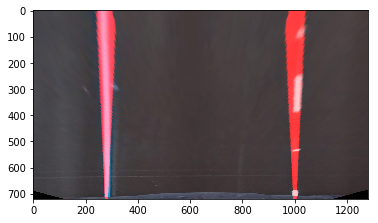

In [28]:

img_size = gray.shape[::-1]
lines_edges
warped_img = cv2.warpPerspective(lines_edges, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped_img)
plt.imsave("output_images/warped_imaged.jpg", warped_img)

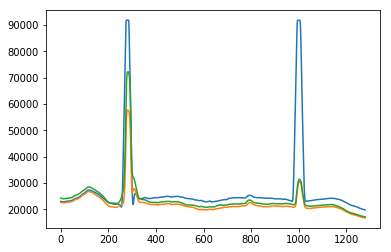

In [29]:
# Detect lane pixels and fit to find the lane boundary.

# Plot histogram

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram



# Create histogram of image binary activations
histogram = hist(warped_img)

# Visualize the resulting histogram
plt.plot(histogram)

In [ ]:
'''
# Take a histogram of the bottom half of the image
histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((warped_img, warped_img, warped_img))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
'''

In [ ]:
'''
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(warped_img.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = ['''

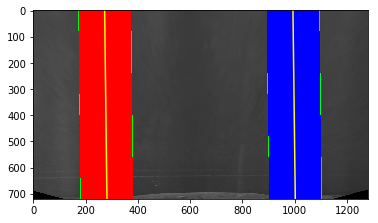

In [30]:
# this function will draw 2 histograms represent the lane lines, 
# draw sliding windows to cover the lanes and identify nonzero pixels
# the following fit_polynomial function will fit a second order polynomial to fit the lane pixels

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

gray_scale = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(gray_scale)

plt.imshow(out_img)

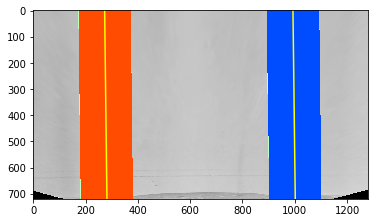

In [31]:
# this cell's functions are used to search the lane pixels around a margin,
# using previous frame's poly fit

# Polynomial fit values from the previous frame

def fit_poly(img_shape, leftx, lefty, rightx, righty, left_fit, right_fit):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, left_fit, right_fit)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    # Fit new polynomials to x,y in world space
    
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty


result, left_fitx, right_fitx, ploty = search_around_poly(gray_scale, left_fit, right_fit)

# View output
plt.imshow(result)

In [32]:
# Determine the curvature of the lane in pixels
# calculate the radius of the curvature of the fit

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)

1.5364784427802248e+16 4442829232135577.5


In [33]:
# Measure the real curvature, in meters

def measure_curvature_real(left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # move to center
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, left_fit_cr, right_fit_cr


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, left_fit_cr, right_fit_cr = measure_curvature_real(left_fitx, right_fitx)

print(left_curverad, 'm', right_curverad, 'm')

5142297554376825.0 m 1219604123916345.8 m


In [36]:
# vehicle position with respect to center

def measure_vehicle_position(left_fitx, right_fitx):
    
    midpoint_lane = (right_fitx[719] + left_fitx[719]) / 2
    midpoint_image = 1280/2
    xm_per_pix = 3.7/700
    offset_pixels = np.abs(midpoint_image - midpoint_lane)
    offset = offset_pixels * xm_per_pix
    
    return offset

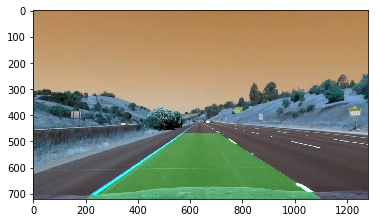

In [37]:
# change perspective back to the road

# Create an image to draw the lines on
warp_zero = np.zeros_like(gray_scale).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = cv2.getPerspectiveTransform(dest_points, src_points)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.imsave("output_images/result.jpg", result)

In [38]:
# I made the left fit and right fit polys global
# need to run this cell for every run of video
left_fit = None
right_fit = None
ploty = None
adjusted_result = None
adjusted_offset = 0
adjusted_left_cr = None
adjusted_right_cr = None
adjusted_left_curverad = 0
adjusted_right_curverad = 0

In [39]:
# This is the main pipeline that combine the procedures above to process frame one by one
# it undists an image, turn it to gray and produce a binary image to highlight the lanes
# Then, it changes the lanes area to bird-eye-view and fit a polynomial to nonzero pixels.
# It changes the image back to original perspective with green area of the lane highlighted.
# It also calculates the lane radius of curvatures and vehicle position with respect to center
# of the image.  Finally, it display the information on the image and return the image.

def process_image(image):
    
    global left_fit
    global right_fit
    global ploty
    global adjusted_result
    global adjusted_offset
    global adjusted_left_cr
    global adjusted_right_cr
    global adjusted_left_curverad
    global adjusted_right_curverad
    
    # get basic info of the image, and make a copy
    ysize = image.shape[0]
    xsize = image.shape[1]
    image_copy = np.copy(image)
    
    # undistort image
    undist_image = cv2.undistort(image_copy, mtx, dist, None, mtx)
    # turn image to gray scale
    gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)
    # apply color analysis and sobel x, return a binary image
    binary_image = binary_pipeline(undist_image, s_thresh=(170, 255), sx_thresh=(100, 200))
    # using the source points and destination points I've decided using one of the image
    # apply a perspective transform
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    # using the vertices I've decided to show only the region of interest
    masked_edges = region_of_interest(binary_image, vertices)
    # get the image size
    img_size = gray.shape[::-1]
    # apply warp perspective transform
    warped_img = cv2.warpPerspective(masked_edges, M, img_size, flags=cv2.INTER_LINEAR)
    # turn the warped image to grayscale
    gray_scale_warped = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
    # detect if it is the first time to detect lane
    
    # draw histograms on the lanes and fit polynomials
    if left_fit is None and right_fit is None:
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(gray_scale_warped)
    elif left_fit is not None and right_fit is not None:    
    # save time and efforts after the first left_fit and right_fit poly were done, 
    # by searching around the polys within a margin
        result, left_fitx, right_fitx, ploty = search_around_poly(gray_scale_warped, left_fit, right_fit)
    
    # measure curvature and vehical offset position
    left_curverad, right_curverad, left_fit_cr, right_fit_cr = measure_curvature_real(left_fitx, right_fitx)
    offset = measure_vehicle_position(left_fitx, right_fitx)
    # take care of the first frame, set 
    if adjusted_left_cr is None:
        adjusted_left_cr = left_fit_cr
        adjusted_right_cr = right_fit_cr
    
    # sanity check for the detected left and right lanes
    # check if curvature is valid
        # check if there is line pixel detected
    if not (left_curverad < 600 or right_curverad < 600) \
        and not (left_fitx is None or right_fitx is None):
        
        # this section is used to draw the green area and change transpose the 
        # warped perspective back to the original image
    
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(gray_scale_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        Minv = cv2.getPerspectiveTransform(dest_points, src_points)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
        
        adjusted_result = result
        adjusted_offset = offset
        adjusted_left_cr = left_fit_cr
        adjusted_right_cr = right_fit_cr
        adjusted_left_curverad = left_curverad
        adjusted_right_curverad = right_curverad
    
    # show the curvatures and vehicle position offset in the image
    cv2.putText(adjusted_result, "Left Radius of Curvature: %d meters" % adjusted_left_curverad, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.putText(adjusted_result, "Right Radius of Curvature: %d meters" % adjusted_right_curverad, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.putText(adjusted_result, "Vehicle Position: %.2f meters offset" % adjusted_offset, (100,300), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    
    return adjusted_result

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:15<00:00,  8.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 2min 16s


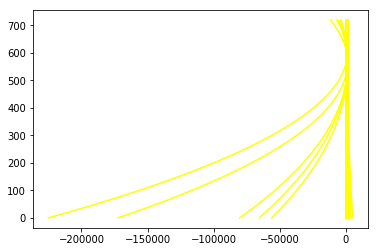

In [41]:
# process the video clip and save the result
output = 'project_output.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(10,15)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
'''
# I made the left fit and right fit polys global
# need to run this cell for every run of video
left_fit = None
right_fit = None
ploty = None
'''

In [ ]:
'''
challenge_output = 'challenge_output.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(15,30)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_output_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_output_clip.write_videofile(challenge_output, audio=False)
'''